In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

In [2]:
X_imputed = pd.read_csv('imputed features_final.csv')
Optimal_Gas = pd.read_csv('Optimal target.csv')

In [3]:
sub_list = list(Optimal_Gas['SubjectID'])

In [4]:
X_imputed = X_imputed[['SubjectID','Age', 'Gender', 'onset_site', 'onset_delta',
       'diag_minus_onset', 'slope_alsfrs_tot',
       'fvc_slope', 'fvc_mean',  'mean_Q10_Respiratory',
       'mean_Bulbar', 'mean_motor', 'slope_Q1_Speech', 'slope_Q2_Salivation',
       'slope_Q3_Swallowing', 'slope_Q4_Handwriting', 'slope_Q5_Cutting',
       'slope_Q6_Dressing_and_Hygiene', 'slope_Q7_Turning_in_Bed',
       'slope_Q8_Walking', 'slope_Q9_Climbing_Stairs', 'slope_Q10_Respiratory']]

In [5]:
X_imputed.query("SubjectID == {0}".format(sub_list), inplace=True)
sub_list_2 = list(X_imputed['SubjectID'])
X_imputed = X_imputed.reset_index()
X_imputed.drop(columns=['index'], inplace=True)

In [6]:
Optimal_Gas.query("SubjectID == {0}".format(sub_list_2), inplace=True)
Optimal_Gas = Optimal_Gas.reset_index()
Optimal_Gas = Optimal_Gas.iloc[:, 1:]
Optimal_Gas.drop(columns='Unnamed: 0', inplace=True)

In [7]:
X_1 = X_imputed.merge(Optimal_Gas, on='SubjectID', how='inner')

In [8]:
X_1 = X_1[X_1['time_opt']!=0]
y = X_1[['status_opt']]
X_2 = X_1.drop(columns='SubjectID')

In [9]:
X_2.drop(columns='Unnamed: 0.1', inplace=True)

# Train/Test split

In [10]:
from sklearn.model_selection import train_test_split

df_train, df_test, y_train, y_test = train_test_split(X_2, y, train_size=0.8, test_size=0.2, random_state=11)

# Creating Virtual Subject with mean values of each feature

In [11]:
VIRT = pd.DataFrame(X_1.mean()).transpose().iloc[:, 1:-3]
VIRT

,Age,Gender,onset_site,onset_delta,diag_minus_onset,slope_alsfrs_tot,fvc_slope,fvc_mean,mean_Q10_Respiratory,mean_Bulbar,...,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory
0,55.158608,0.635908,0.173257,-611.316627,339.619399,-0.023368,-0.082875,83.904941,3.606309,6.814276,...,-0.0015,-0.001109,-0.000895,-0.00247,-0.003277,-0.003562,0.011939,-0.002192,-0.004155,-0.001381


# Fitting model

Cox Proportion Hazard model

In [12]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01)
cph.fit(df_train, 'time_opt', event_col='status_opt')

<lifelines.CoxPHFitter: fitted with 2713 total observations, 2184 right-censored observations>

In [22]:
result_cph = cph.predict_survival_function(VIRT)

Random Survival Forest

In [14]:
from sksurv.ensemble import RandomSurvivalForest

In [15]:
dic = {1:True, 0:False}

df_train_rsf = df_train.iloc[:, -2:][['status_opt', 'time_opt']]
df_train_rsf = df_train_rsf.replace({'status_opt':dic})

In [16]:
arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt=np.dtype('bool, float')
y_train_rsf = np.array(arr_1, dtype=dt)
y_train_rsf.dtype.names=['cens', 'time']

In [19]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=20)
rsf.fit(df_train.iloc[:,:-2], y_train_rsf)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=20)

In [20]:
result_rsf = rsf.predict_survival_function(VIRT, return_array=True)

In [50]:
from lifelines.utils import median_survival_times

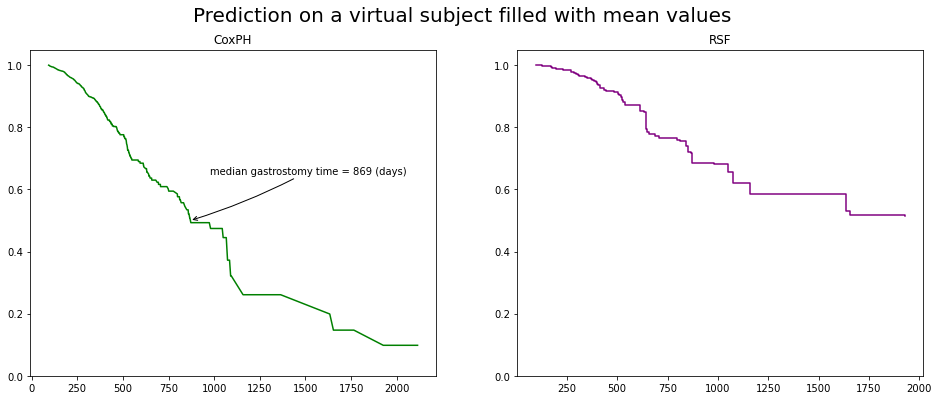

In [84]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.plot(result_cph.index, result_cph, marker='None', color='green')
plt.title("CoxPH")
plt.ylim([0,1.05])
plt.annotate("median gastrostomy time = 869 (days)", xy=(869, 0.5)
                , xytext=(869+110, 0.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.05"))

plt.subplot(122)
for i, s in enumerate(result_rsf):
    plt.step(rsf.event_times_, s, where="post", color='purple')
plt.ylim([0,1.05])
plt.title('RSF')

plt.suptitle('Prediction on a virtual subject filled with mean values', fontsize=20)
plt.show()

In [80]:
result_cph[result_cph[0]<=0.51].head()

,0
866.0,0.507294
867.0,0.507294
872.0,0.492966
879.0,0.492966
883.0,0.492966
